## Setup

In [1]:
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
creds = 'xxx'
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.mk_write(creds)
    cred_path.chmod(0o600)

In [4]:
from kaggle import api

## Data

In [5]:
path = URLs.path('bluebook')
path

Path('/root/.fastai/archive/bluebook')

In [6]:
if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli('bluebook-for-bulldozers', path=path)
    file_extract(path/'bluebook-for-bulldozers.zip')

  0%|          | 0.00/48.4M [00:00<?, ?B/s]

100%|██████████| 48.4M/48.4M [00:00<00:00, 65.4MB/s]


In [7]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [8]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [9]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [10]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [11]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

## Decision Trees

In [12]:
df = add_datepart(df, 'saledate')

In [13]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [14]:
procs = [Categorify, FillMissing]

In [15]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [16]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [17]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [18]:
len(to.train), len(to.valid)

(404710, 7988)

In [19]:
save_pickle(path/'to.pkl', to)

In [20]:
to = load_pickle(path/'to.pkl')

In [21]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [22]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs,y);

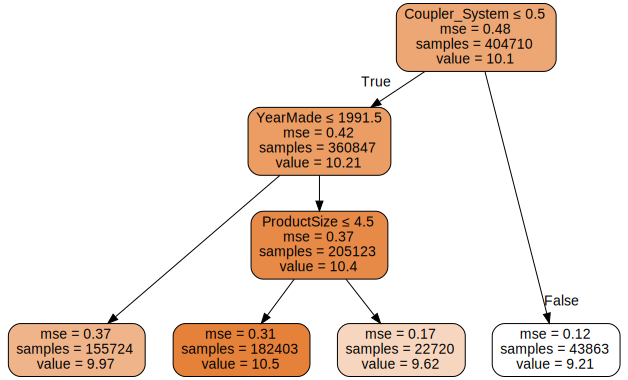

In [23]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

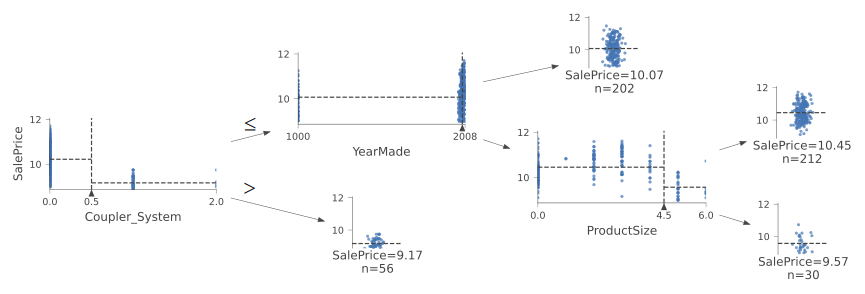

In [24]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [25]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

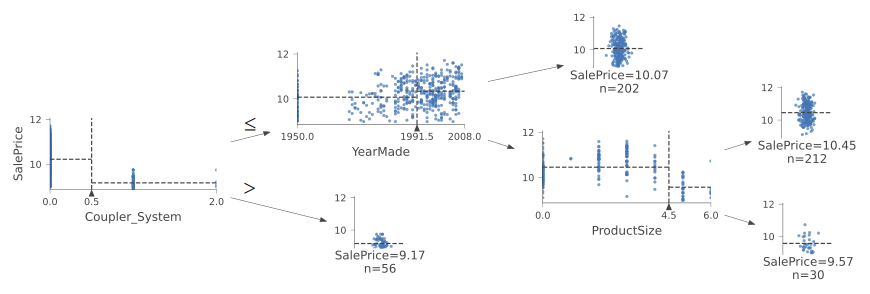

In [26]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs,y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [27]:
m = DecisionTreeRegressor().fit(xs,y)

In [28]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [29]:
m_rmse(m, xs, y)

1e-06

In [30]:
m_rmse(m, valid_xs, valid_y)

0.332913

In [31]:
m.get_n_leaves(), len(xs)

(324528, 404710)

In [32]:
m = DecisionTreeRegressor(min_samples_leaf=25).fit(xs,y)

In [33]:
m_rmse(m,xs,y), m_rmse(m,valid_xs,valid_y)

(0.211706, 0.268875)

In [34]:
m.get_n_leaves()

12400

## Random Forest

In [35]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [36]:
m = rf(xs,y);

In [37]:
m_rmse(m,xs,y), m_rmse(m,valid_xs,valid_y)

(0.170966, 0.232699)

In [38]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
r_mse(preds.mean(0), valid_y)

0.232699

## Feature Importance

In [39]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [40]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
57,YearMade,0.173023
6,ProductSize,0.117253
30,Coupler_System,0.117053
7,fiProductClassDesc,0.073112
54,ModelID,0.054777
65,saleElapsed,0.048835
3,fiSecondaryDesc,0.046104
31,Grouser_Tracks,0.041196
12,Enclosure,0.040495
32,Hydraulics_Flow,0.032725


In [41]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

21

In [42]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [43]:
m = rf(xs_imp, y)

In [44]:
m_rmse(m,xs_imp,y), m_rmse(m,valid_xs_imp,valid_y)

(0.18131, 0.230503)

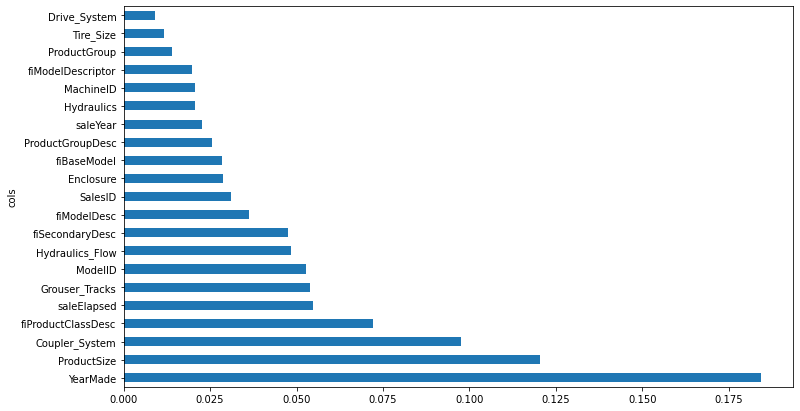

In [45]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(rf_feat_importance(m, xs_imp));

## Removing Redudant Features

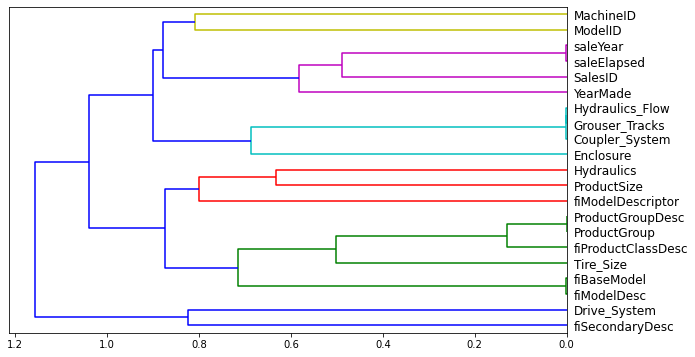

In [46]:
cluster_columns(xs_imp)

In [47]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [48]:
get_oob(xs_imp)

0.8781576734893485

In [49]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'Coupler_System': 0.8770165273393064,
 'Grouser_Tracks': 0.8775565092698138,
 'Hydraulics_Flow': 0.8774995916903535,
 'ProductGroup': 0.8778594920344923,
 'ProductGroupDesc': 0.8770087512874477,
 'fiBaseModel': 0.8761168180455399,
 'fiModelDesc': 0.8754781084425128,
 'saleElapsed': 0.8722097904682757,
 'saleYear': 0.8768628311464004}

In [50]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8750482697068109

In [51]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [52]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

In [53]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

In [54]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183251, 0.232259)

## Partial Dependence

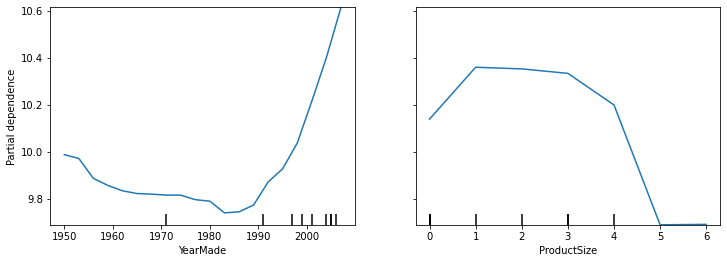

In [55]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

## Tree Interpreter

In [56]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [57]:
row = valid_xs_final.iloc[:5]
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [58]:
prediction[0], bias[0], contributions[0].sum()

(array([9.94708073]), 10.104746057831763, -0.15766532528651994)

In [59]:
prediction[0], bias[0], contributions[0]

(array([9.94708073]),
 10.104746057831763,
 array([-0.44016915,  0.14497252,  0.06258609,  0.00081438,  0.14474043, -0.01560025, -0.07856491, -0.01258935,  0.02717539,  0.08056786, -0.04688832, -0.0098789 , -0.02834407,  0.02706551,
         0.01411586,  0.00213262, -0.02980106]))

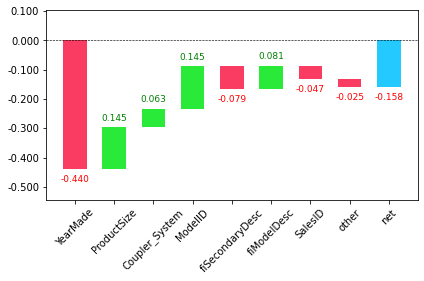

In [60]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

## Extrapolation

In [61]:
np.random.seed(42)
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)

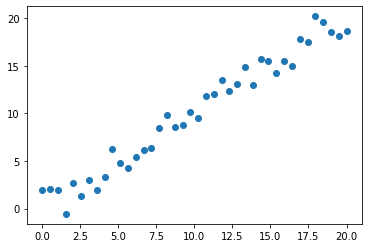

In [62]:
plt.scatter(x_lin, y_lin)

In [63]:
xs_lin = x_lin[:,None]
xs_lin.shape

torch.Size([40, 1])

In [64]:
m_lin = RandomForestRegressor().fit(xs_lin[:30], y_lin[:30])

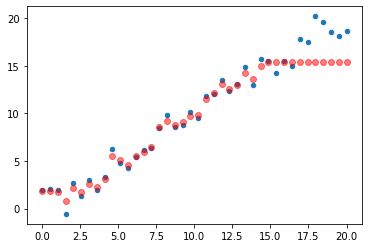

In [65]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5)

## Finding out of domain data

In [66]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.858008
10,SalesID,0.098377
13,MachineID,0.035284
0,YearMade,0.002645
4,ModelID,0.001238
7,Enclosure,0.000891


In [67]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.231847
SalesID 0.231492
saleElapsed 0.235826
MachineID 0.231672


In [68]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.228826

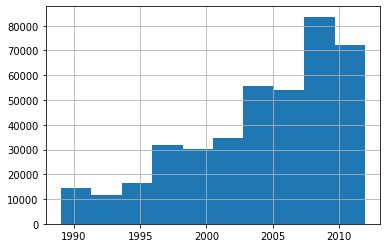

In [69]:
xs['saleYear'].hist()

In [70]:
filt = xs['saleYear'] > 2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [71]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.177757, 0.229866)

## Neural Network

In [72]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [73]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [74]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [75]:
cont_nn

['saleElapsed']

In [76]:
df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Enclosure                6
Hydraulics_Flow          3
fiModelDesc           5059
ProductGroup             6
fiModelDescriptor      140
Hydraulics              12
Drive_System             4
Tire_Size               17
dtype: int64

In [77]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.176845, 0.229738)

In [78]:
cat_nn.remove('fiModelDescriptor')

In [79]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [80]:
dls = to_nn.dataloaders(1024)

In [81]:
y = to_nn.train.y
y.min(),y.max()

(8.465899467468262, 11.863582611083984)

In [82]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.00015848931798245758)

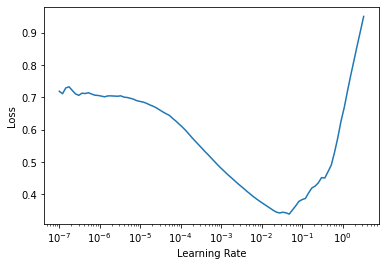

In [83]:
learn.lr_find()

In [84]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.062847,0.062322,00:05
1,0.054275,0.056857,00:05
2,0.047491,0.056611,00:05
3,0.043443,0.050825,00:05
4,0.040261,0.050489,00:05


In [85]:
preds, targs = learn.get_preds()
r_mse(preds, targs)

0.224699

In [86]:
learn.save('nn')

Path('models/nn.pth')

In [87]:
rf_preds = m.predict(valid_xs_time)

In [88]:
rf_preds.shape

(7988,)

In [89]:
preds.shape

torch.Size([7988, 1])

In [90]:
ens_preds = (to_np(preds.squeeze()) + rf_preds)/2
r_mse(ens_preds, valid_y)

0.222184

Better than individual results from RF or DL

## Boosting